# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Problem Statement

Starbucks usually sends out offers to their users and these offers include buy-one-get-one (BOGO) offers, discount offers and informational offers which promote a new product for example. The users of course vary in terms of income, age, gender and most importantly how they respond to the offer received. Therefore, we want to take a close look at our user demographics, the offers sent out and how both factor into action done in the end by the user.
We want to eventually be answering these following questions: \
1 - What are the age groups that use the app most frequently? \
2 - What are the offer types that each age group receive? \
3 - What are the incomes of people that have used each offer type? \
4 - What is the ratio of offer completion for old and new app users? \
5 - What is the ratio of offer receival to view for each offer type? \
6 - What is the ratio of offer completion to view for each offer type? \
<br>
### Strategy & Metrics

First, I will take a look at the data briefly and see if it needs any cleaning/duplicate removal/imputation. Then, I will feature engineer any features that might aid me in answering the above questions. Then, I will combine all the data into one single dataframe. Finally, performing visualizations will be done to answer these questions.\
**Note:** In this project, I will not be using a machine learning model to predict a user's response to an offer for example. Instead, I believe data visualizations will best help answer the above questions of interest. 

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [59]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [60]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [61]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [62]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [63]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Initial Data Cleaning (if needed)

In [64]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [65]:
portfolio.shape

(10, 6)

In [66]:
portfolio.channels.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

> Those values will be one-hot encoded in the feature engineering part

In [67]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [68]:
profile[profile.gender.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


> It seems that those with missing gender also have income missing. Also, the age seems to be 118 only but let's confirm

In [69]:
print(profile[profile.gender.isnull()].age.value_counts())
print()
print(profile[profile.gender.isnull()].income.value_counts())

118    2175
Name: age, dtype: int64

Series([], Name: income, dtype: int64)


> Those rows represent about 1.2% of the dataframe so I think we can safely remove them from the profile and transcript dataframes

In [70]:
have_nans = profile[profile.gender.isnull()]
have_nans_ids = have_nans.id.tolist()
profile = profile[~profile.id.isin(have_nans_ids)]
transcript = transcript[~transcript.person.isin(have_nans_ids)]

In [71]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [72]:
# Check for duplicates
profile[profile.duplicated() == True]

,gender,age,id,became_member_on,income


In [73]:
# Change the became_member_on column to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [74]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [75]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  272762 non-null  object
 1   event   272762 non-null  object
 2   value   272762 non-null  object
 3   time    272762 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


> I will check for duplicates in the next part because the value column returns an error when I look for duplicates because it has a dictionary as a value

## Feature Engineering

#### 1- One hot encode channels column in the portfolio data
#### 2- One hot encode gender column in the profile data
#### 3- Extract offer ids from the value column in the transcript data
#### 4- Divide ages to age groups in the profile data
#### 5- Make old/new member column based on the became_member_on column in the profile data

In [76]:
# One hot encode channels column in the portfolio data
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

portfolio = portfolio.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(portfolio.pop('channels')),
                index=portfolio.index,
                columns=mlb.classes_))

offer_types = pd.get_dummies(portfolio.offer_type)
portfolio = portfolio.join(offer_types)
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [77]:
# portfolio.drop(columns='offer_type', inplace = True)
# portfolio.head()

In [78]:
# One hot encode gender column in the profile data
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [79]:
genders = pd.get_dummies(profile.gender)
profile = profile.join(genders)
# I will drop the other column as it is not really useful
profile.drop(columns=['gender','O'], inplace = True)
profile.head()

,age,id,became_member_on,income,F,M
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0
5,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1
8,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1
12,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1


In [80]:
# Extract offer ids from the value column in the transcript data
transcript['offer_id'] = transcript['value'].apply(lambda x: list(x.values())[0]) # Get the value part from the dictionary
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: x if len(str(x)) > 20 else np.nan) # Remove transaction amount from the column

In [81]:
# Resetting index
transcript= transcript.reset_index(drop=True)
transcript.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [82]:
# Check for duplicates
indices_to_be_dropped = transcript[transcript[['person','event','time', 'offer_id']].duplicated() == True].index

In [83]:
# Drop ducplicates
transcript.drop(index = indices_to_be_dropped,  inplace = True)

In [84]:
transcript[transcript[['person','event','time', 'offer_id']].duplicated() == True]

,person,event,value,time,offer_id


In [85]:
# Divide ages to age groups in the profile data
profile.age.min(), profile.age.max()

(18, 101)

In [86]:
profile['age_groups'] = pd.cut(x=profile['age'], bins=[17, 24, 35, 48, 64, 102], labels=['18-24', '24-35', '35-48', '48-64', '64-101'])
profile.age_groups.value_counts()

48-64     5471
64-101    4266
35-48     2714
24-35     1498
18-24      876
Name: age_groups, dtype: int64

In [87]:
profile.head(3)

,age,id,became_member_on,income,F,M,age_groups
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,48-64
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,64-101
5,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,64-101


In [88]:
# Make old/new member column based on the became_member_on column in the profile data
profile.became_member_on.min(), profile.became_member_on.max(), (profile.became_member_on.max() - profile.became_member_on.min()) / 2

(Timestamp('2013-07-29 00:00:00'),
 Timestamp('2018-07-26 00:00:00'),
 Timedelta('911 days 12:00:00'))

> So the middle date should be 2016-1-16, so any date before this it we will consider an old member and any date after is new

In [89]:
# profile['membership'] = profile[profile.became_member_on ]
profile.loc[(profile.became_member_on <= '2016-1-16'), 'user_member'] = 'old'
profile.loc[(profile.became_member_on > '2016-1-16'), 'user_member'] = 'new'

## Exploratory Data Analysis

### Portfolio data

In [90]:
portfolio[portfolio.bogo == 1]

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0


> The bogo offers return the same reward amount as the difficulty, Usually last for 5-7 days and are advertised through at least 3 channels

In [91]:
discount_offers = portfolio[portfolio.discount == 1]
discount_offers

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [92]:
(discount_offers.reward / discount_offers.difficulty).mean()

0.26964285714285713

> The discount offers are typically 27% discounts, Usually last for 7-10 days and are also advertised through at least 3 channels

In [93]:
portfolio[portfolio.informational == 1]

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1


> Nothing really too special to notice about informational offers except that they are advertised for a shorter duration than bogo and discount offers

### Profile data

### Question 1: What are the age groups that use the app most frequently?

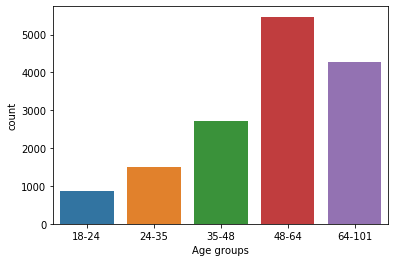

In [94]:
sb.countplot(x="age_groups", data=profile);
plt.xlabel('Age groups');

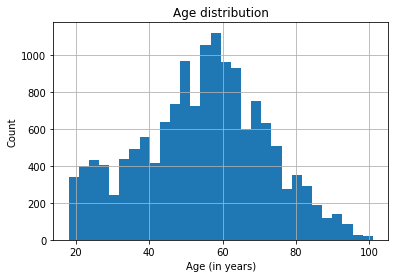

In [95]:
# Just checking age distribution
profile.age.hist(bins=30);
plt.xlabel('Age (in years)');
plt.ylabel('Count');
plt.title('Age distribution');

> Surprisingly, ages 45-65 are the most frequent that use the Starbucks app. Also worth noting is that the age sort of follows a gaussian distribution

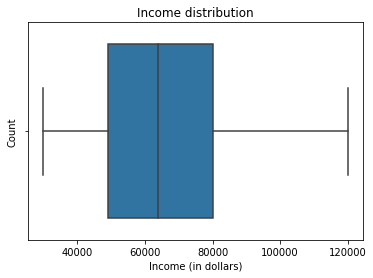

In [96]:
sb.boxplot(x=profile["income"]);
plt.xlabel('Income (in dollars)');
plt.ylabel('Count');
plt.title('Income distribution');

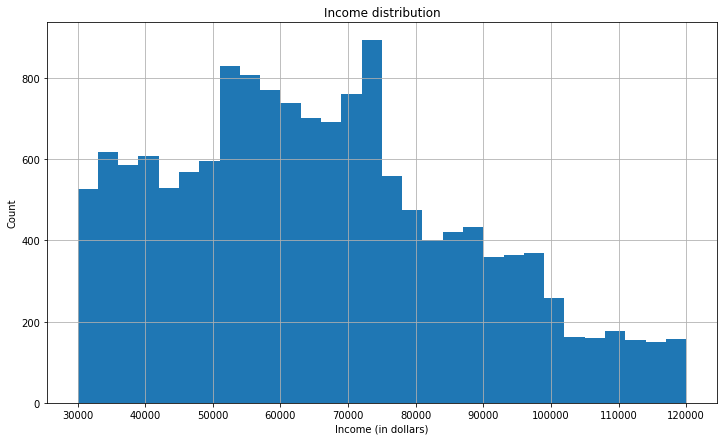

In [97]:
plt.figure(figsize=(12,7))
profile.income.hist(bins=30);
plt.xticks(np.arange(30000, 130000, 10000));
plt.xlabel('Income (in dollars)');
plt.ylabel('Count');
plt.title('Income distribution');

> Nothing unordinary here really in terms of income distribution

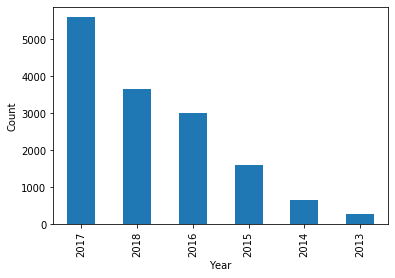

In [98]:
temp = profile.copy()
temp['year'] = profile.became_member_on.dt.year
temp.year.value_counts().plot(kind='bar');
plt.xlabel('Year');
plt.ylabel('Count');

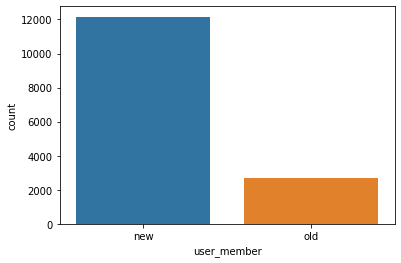

In [99]:
sb.countplot(x='user_member', data = profile);

> It seems that most of our starbucks app users are more recent ones.

### Transcript data 

In [100]:
transcript.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7


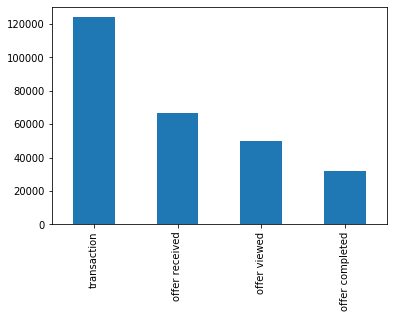

In [101]:
transcript.event.value_counts().plot(kind='bar');

> This plot actually tells us alot. People don't view every offer they receive and about 50% of the time, people don't complete the offer(s) they receive even though the number of transactions is huge on the app.

### Before we continue with out analysis and question answering, I want to make one single dataframe that holds all our data to help us with the analysis. Also, to ease answering some of the questions, I will create 3 seprate dataframes for bogo transactions, discount transactions and informational transactions. 

#### Bogo & Discount offers contain all 4 steps in case of an offer completion while informational offers only have the first 3 (receiving, viewing and transaction)
#### This represents a slight issue since transaction rows don't show if the transaction included the offer. So a possible solution is to get all viewing offer events and transactions events in a dataframe and then sort that dataframe by the person id then by the time of event. That way if a an offer was viewed than was followed by a transaction, we can safely assume that this transaction included the offer viewed.

In [102]:
view_and_transaction = transcript[['person','event','time','offer_id']]
                                [(transcript['event']=='transaction') | (transcript['event']=='offer viewed')]
view_and_transaction.sort_values(by=['person', 'time'], inplace = True)
view_and_transaction.fillna(method="ffill", limit = 1, inplace = True) # Only impute the first following missing value 

In [103]:
# Add the imputations to our transcript dataframe
transcript.loc[view_and_transaction.index, ['offer_id']] = view_and_transaction[['offer_id']]

In [104]:
# Creating one dataframe that includes the data of our 3 dataframes
transcript_profile = pd.merge(transcript, profile, left_on='person', right_on = 'id', how='left')
final_transcript = pd.merge(transcript_profile, portfolio, left_on='offer_id', right_on = 'id', how='left')
final_transcript.head()

,person,event,value,time,offer_id,age,id_x,became_member_on,income,F,...,duration,offer_type,id_y,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,...,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,...,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,...,5.0,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,...,4.0,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,1,...,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [105]:
final_transcript.columns

Index(['person', 'event', 'value', 'time', 'offer_id', 'age', 'id_x',
       'became_member_on', 'income', 'F', 'M', 'age_groups', 'user_member',
       'reward', 'difficulty', 'duration', 'offer_type', 'id_y', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [106]:
# Removing repeated columns
final_transcript = final_transcript[['person', 'event', 'value', 'time', 'offer_id', 'age', 'became_member_on', 'income', 
                                     'F', 'M', 'age_groups', 'offer_type','user_member', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'bogo',
                                     'discount', 'informational']]

In [107]:
final_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272388 entries, 0 to 272387
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype             
---  ------            --------------   -----             
 0   person            272388 non-null  object            
 1   event             272388 non-null  object            
 2   value             272388 non-null  object            
 3   time              272388 non-null  int64             
 4   offer_id          189265 non-null  object            
 5   age               272388 non-null  int64             
 6   became_member_on  272388 non-null  datetime64[ns]    
 7   income            272388 non-null  float64           
 8   F                 272388 non-null  uint8             
 9   M                 272388 non-null  uint8             
 10  age_groups        272388 non-null  category          
 11  offer_type        189265 non-null  object            
 12  user_member       272388 non-null  object            
 13 

In [108]:
# convert_dict = {'reward': int,
#                 'difficulty': int,
#                 'duration': int,
#                 'email': int,
#                 'mobile': int,
#                 'social': int,
#                 'web': int,
#                 'bogo': int,
#                 'discount': int,
#                 'informational': int
#                }
  
# final_transcript = final_transcript.astype(convert_dict)
# final_transcript.info()

In [109]:
# 3 dataframes for each offer type
bogo_ids = portfolio[portfolio.bogo == 1]['id'].values
discount_ids = portfolio[portfolio.discount == 1]['id'].values
informational_ids = portfolio[portfolio.informational == 1]['id'].values

bogo_transcripts = final_transcript[final_transcript.offer_id.isin(bogo_ids)]
discount_transcripts = final_transcript[final_transcript.offer_id.isin(discount_ids)]
informational_transcripts = final_transcript[final_transcript.offer_id.isin(informational_ids)]

### Continuing with the analysis and visualizations

### Question 2: What are the offer types that each age group receive?

In [118]:
received_offers = final_transcript[final_transcript.event == 'offer received']

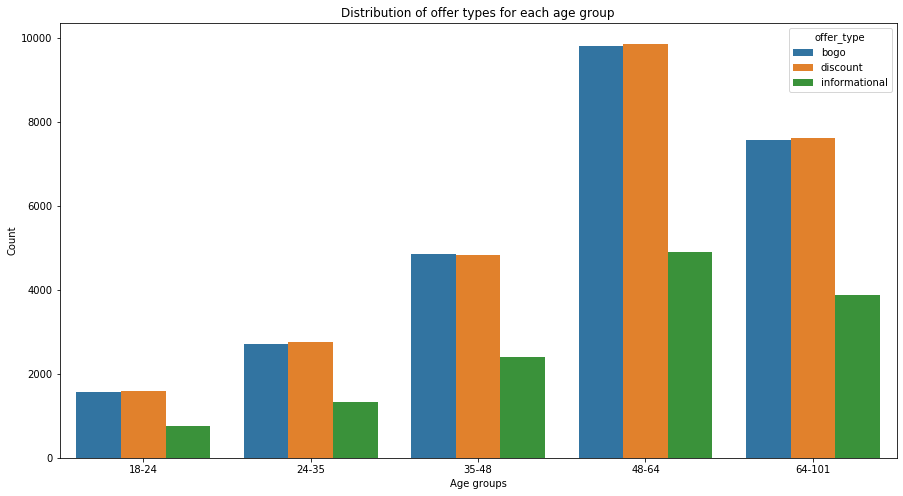

In [119]:
plt.figure(figsize=(15, 8))
sb.countplot(x= "age_groups", hue= "offer_type", data=received_offers);
plt.xlabel('Age groups');
plt.ylabel('Count');
plt.title('Distribution of offer types for each age group');

> Multiple things we observe here, first the percentage of informational offers sent is less than the bogo and discount offers by 50% (Although this might be because we have 2 informational offers, 4 bogo and 4 discount offers). Second thing is across all age groups, the number of bogo offers is almost similar to the number of discount offers. Third thing is that Starbucks seems to be targetting the older age groups with its offers, especially the 48-64 age group.

### Question 3: What are the incomes of people that have used each offer type?

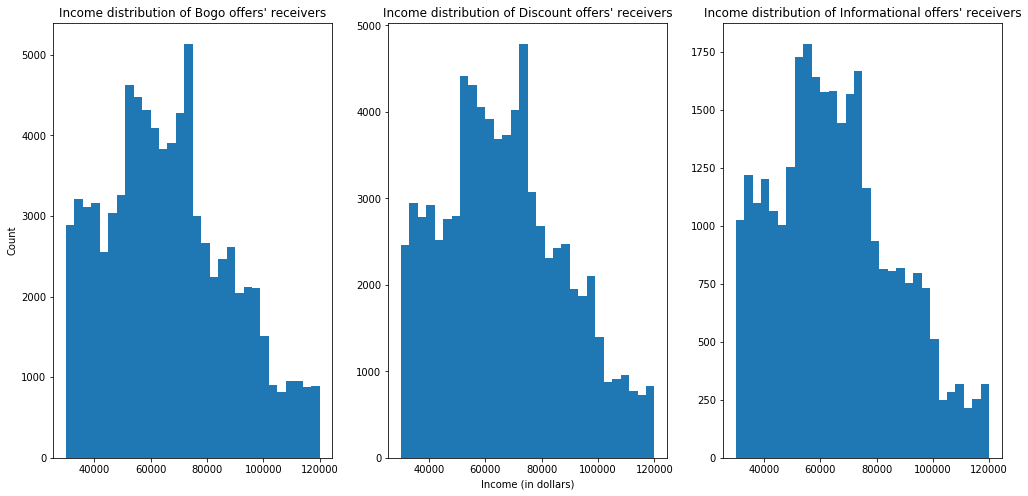

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(17, 8))

n_bins = 30 
ax[0].hist(bogo_transcripts.income, n_bins)
ax[0].set_title("Income distribution of Bogo offers' receivers");

ax[1].hist(discount_transcripts.income, n_bins)
ax[1].set_title("Income distribution of Discount offers' receivers");

ax[2].hist(informational_transcripts.income, n_bins)
ax[2].set_title("Income distribution of Informational offers' receivers");

ax[1].set_xlabel('Income (in dollars)');
ax[0].set_ylabel('Count');

plt.show()

> Suprisingly, there is no visible pattern between offer types and income. All 3 have the same distribution pretty much.

### Question 4: What is the ratio of offer completion for old and new app users?

In [141]:
bogo_completed = bogo_transcripts[bogo_transcripts.event == 'offer completed']
discount_completed = discount_transcripts[discount_transcripts.event == 'offer completed']

informational_without_na = informational_transcripts.dropna()
informational_completed = informational_without_na[informational_without_na.event == 'transactions']
all_completed = pd.concat([bogo_completed, discount_completed, informational_completed])

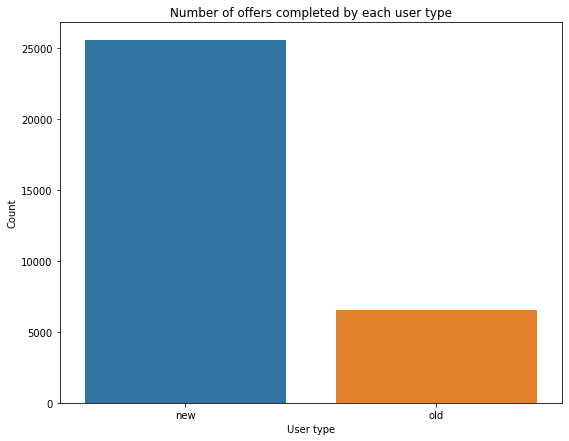

In [146]:
plt.figure(figsize=(9,7));
sb.countplot(x = 'user_member', data = all_completed);
plt.xlabel('User type');
plt.ylabel('Count');
plt.title('Number of offers completed by each user type');

> Surprisingly, the number of completed offers by newer members is more than 4 times the number of completed offers by older members. Maybe users hunt for offers as an excuse to start using the app.

### Question 5: What is the ratio of offer receival to view for each offer type?

In [106]:
bogo_view_percent = (bogo_transcripts[bogo_transcripts.event == 'offer viewed'].shape[0] / bogo_transcripts[bogo_transcripts.event == 'offer received'].shape[0]) * 100
discount_view_percent = (discount_transcripts[discount_transcripts.event == 'offer viewed'].shape[0] / discount_transcripts[discount_transcripts.event == 'offer received'].shape[0]) * 100
informational_view_percent = (informational_transcripts[informational_transcripts.event == 'offer viewed'].shape[0] / informational_transcripts[informational_transcripts.event == 'offer received'].shape[0]) * 100

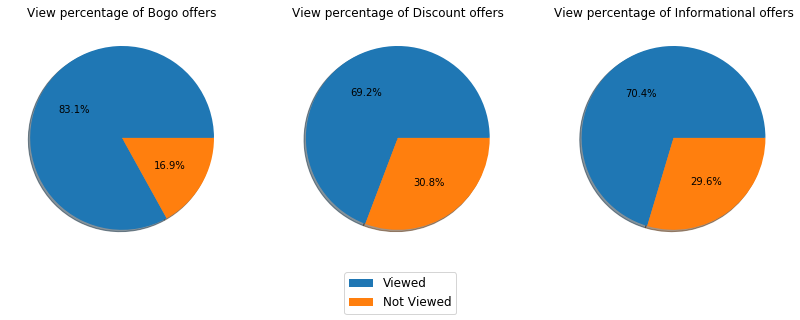

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
bogo_view_ratio = [bogo_view_percent, 100-bogo_view_percent]
discount_view_ratio = [discount_view_percent, 100-discount_view_percent]
info_view_ratio = [informational_view_percent, 100-informational_view_percent]


ax[0].pie(bogo_view_ratio, autopct='%1.1f%%', shadow = True)
ax[0].set_title('View percentage of Bogo offers')

ax[1].set_title('View percentage of Discount offers')
ax[1].pie(discount_view_ratio, autopct='%1.1f%%', shadow = True)

ax[2].set_title('View percentage of Informational offers')
ax[2].pie(info_view_ratio, autopct='%1.1f%%', shadow = True)
fig.legend(['Viewed', 'Not Viewed'], loc='lower center', fontsize = 'large')
plt.show()

> Bogo offers seem to catch the attention of the users more than informational and dicount offers. I expected discount offers to have a more viewing percentage than 69.2% percent.

### Question 6: What is the ratio of offer view to completion for each offer type?

In [88]:
bogo_completed_percent = (bogo_transcripts[bogo_transcripts.event == 'offer completed'].shape[0] / bogo_transcripts[bogo_transcripts.event == 'offer received'].shape[0]) * 100
discount_completed_percent = (discount_transcripts[discount_transcripts.event == 'offer completed'].shape[0] / discount_transcripts[discount_transcripts.event == 'offer received'].shape[0]) * 100

informational_completed_percent = (informational_without_na[informational_without_na.event == 'transaction'].shape[0] / informational_without_na[informational_without_na.event == 'offer received'].shape[0]) * 100

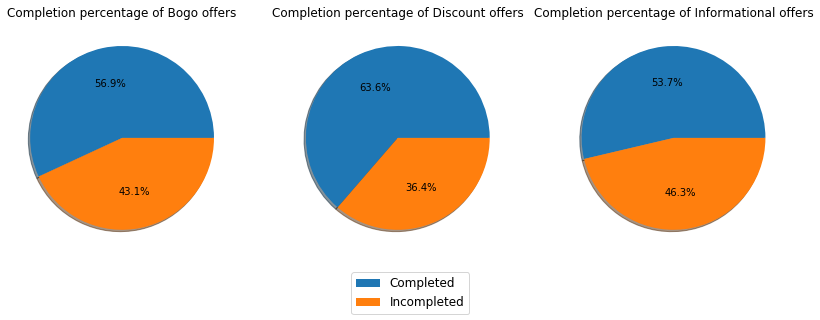

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
bogo_ratio = [bogo_completed_percent, 100-bogo_completed_percent]
discount_ratio = [discount_completed_percent, 100-discount_completed_percent]
info_ratio = [informational_completed_percent, 100-informational_completed_percent]


ax[0].pie(bogo_ratio, autopct='%1.1f%%', shadow = True)
ax[0].set_title('Completion percentage of Bogo offers')

ax[1].set_title('Completion percentage of Discount offers')
ax[1].pie(discount_ratio, autopct='%1.1f%%', shadow = True)

ax[2].set_title('Completion percentage of Informational offers')
ax[2].pie(info_ratio, autopct='%1.1f%%', shadow = True)
fig.legend(['Completed', 'Incompleted'], loc='lower center', fontsize = 'large')
plt.show()

> A couple of things to notice here: \
> 1- About 50% of the time people don't complete the informational offers that they receive and view \
> 2- Despite people viewing Bogo offers more often than discount offers, Discount offers have more completion percentage than Bogo offers with about 64% of users complete their dicount offers while Bogo offers are completed 57% of the time only 

# Conclusion
## Reflections

In this project, we were provided with three datasets that simulated how people usually interact with Starbucks' app and offers and also provided us with data about those users' demographics and about the nature of the offers. What I did was try and make use of all this data to provide insights into which offers are most successful and try to understand the behaviour of the users towards the offers provided through these questions: \
1 - What are the age groups that use the app most frequently? \
2 - What are the offer types that each age group receive? \
3 - What are the incomes of people that have used each offer type? \
4 - What is the ratio of offer completion for old and new app users? \
5 - What is the ratio of offer receival to view for each offer type? \
6 - What is the ratio of offer completion to view for each offer type? \
\
\
For Q1: We found out that ages 45-65 are the most frequent that use the Starbucks app.\
Q2: The percentage of informational offers sent is less than the bogo and discount offers by 50% across all age groups. Also, the number of bogo offers is almost similar to the number of discount offers across all age groups \
There was no useful finding when answering Q3 unfortunately \
Q4: The number of completed offers by newer members is more than 4 times the number of completed offers by older members. \
Q5: Bogo offers were the most viewed offers (83.1%) followed by informational offers (70.2%) followed by discount offers (69.2%) \
Q6: Discount offers were the most viewed offers (63.6%) followed by bogo offers (56.9%) followed by informational offers (53.7%) 

## Improvement

A classification machine learning model could be used where we give it the offer type and user demographics for example and the model predicts whether the user will complete the offer or not.